# Multiple Object Tracking using robust appearance representations

### Intro

In this demo I used robust CNN features to track cars and pedestrians in [KITTI tracking dataset](http://www.cvlibs.net/datasets/kitti/eval_tracking.php) videos. I followed the tracking-by-detection framework which detects objects in each frame and then correlates the objects among frames. For this purpose I used the [Mask RCNN detector](https://github.com/matterport/Mask_RCNN) which returns bounding boxes, pixel masks and the class of each detected object.

### Timings

A MOT system for cars should be online and real-time. By real time I mean that future frames are not used. By real time I mean that the system should yield results in a decent rate (optimally near the frame rate of the camera recordings). 

In [1]:
from datetime import datetime 

### Imports

Useful packages

In [2]:
import skimage.io
import os, sys
from os.path import isfile, join
from os import listdir
import uuid
import numpy as np
np.set_printoptions(precision=3)
import pickle
import cv2

from scipy.optimize import linear_sum_assignment

from matplotlib import pyplot as plt
%matplotlib inline 

Importing from mrcnn (mask RCNN), coco (coco dataset api) and trcnn (my implementation of tracking).

In [3]:
ROOT_DIR = os.path.abspath("./")

sys.path.append(ROOT_DIR)  # To find local version of the library
from trcnn.utils import squarify, keepClasses, simple_dist, box_dist, tensor2vec, \
						pyr_sizes, num_particles, bbs, random_sampling
import trcnn.model as tracker
from trcnn.model import trackedObject as tob
from trcnn.model import normalize_boxes
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  
import coco

# Import measurement for tracking 
from measurements import  save_instances,  save_statistics

Using TensorFlow backend.


### Initialization and preparation of the detector, the input data and the appearance feature extractor

For convenience I have pre-calculated the detection data for each frame into pickle files. Normally it takes up to 6 seconds in my gtx 960 GPU but it can be made to run in more than 5 fps on a heavy duty GPU. The detector is trained using the [COCO dataset](http://cocodataset.org/). 

In [4]:
input_dir =  '/home/anthony/maskrcnn/Mask_RCNN/datasets/training/image_02/0017'
pickle_dir = '/home/anthony/maskrcnn/Mask_RCNN/samples/pickles/0017'

# Saved detections
pickles = sorted([f for f in listdir(pickle_dir) if isfile(join(pickle_dir, f))])

# Relevant classes
classes_det = ['Car', 'Pedestrian']

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Output tracking file name
trackf = input_dir[-4:] + '.txt'

# COCO Class names
# Index of the class in the list is its ID. 
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Match KITTI class names
class_names[class_names.index('person')] = 'Pedestrian'
class_names[class_names.index('car')]    = 'Car'

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Read frame names from folder
IMAGE_DIR = input_dir
frames = sorted([f for f in listdir(IMAGE_DIR) if isfile(join(IMAGE_DIR, f))])

# Initialize model for Appearance features for boxes
roi_model = tracker.RoiAppearance(config=config)

### 'Computing' detections for the first frame
Detections are structured as a dictionary containing (mostly) numpy matrices:

* "rois":      bounding boxes of detected objects in image coordinates
* "class_ids": class of detected objects
* "scores":    confidence of class of detected objects
* "masks":     original image with 1s where the detected object and 0s otherwise
* "fp_maps":   a list of pyramid feature maps tensors
* "metas":     image information (size etc)
* "detections":bounding boxes of detected objects in normalized coordinates

#### Feature pyramids
Detections are made in different scales of the image. For this reason the detector uses different feature maps for different scales which is implemented using [feature pyramid networks](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c).

I have tweaked the mask rcnn to output the feature maps. I use these feature maps to extract robust descriptions of the detected objects.

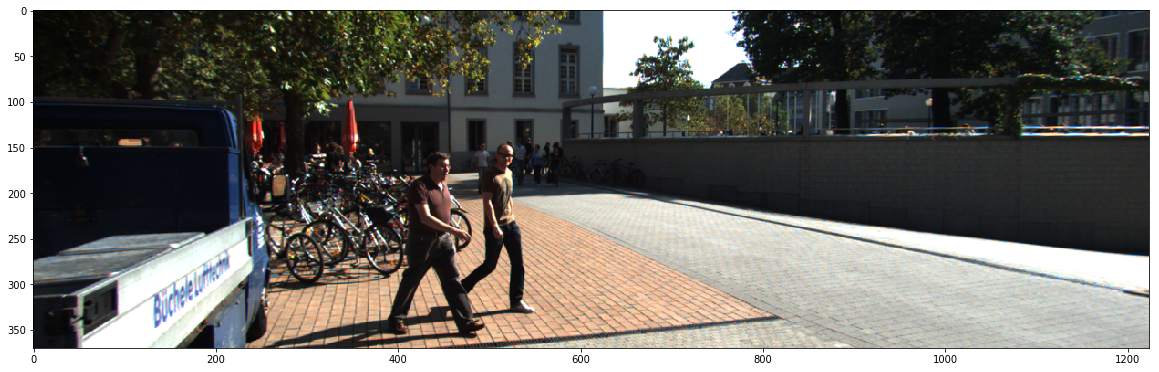

In [5]:
# read first image
image = skimage.io.imread(os.path.join(IMAGE_DIR,frames[0]))

plt.figure(figsize=(20,20))
plt.imshow(image)

# detections are saved as a dictionary 
f = open(join(pickle_dir, pickles[0]),'rb')
r = pickle.load(f)

# Read detections from model output (detections contain rois in normalized coords)
rois = r['detections'][:,:,0:4]

### Encoding appearance information for each detected object

For each detected object I sample randomly a set of points inside the object mask. For these points I extract bounding boxes in two pyramid scales (In this demo I use only one). For each such bounding box I extract 3x3x256 feature tensors (flattened into a 3x3x256 dimensional 1D feature vector) using [Roi Pooling](https://i.stack.imgur.com/rJL7D.gif) in the correct feature pyramid scale. I also save the sampled point coordinates.

This way we end up with a particle-like description of each object. There are multiple reasons for using this representation. First, I use already computed features from the detection step to save time. Also, these features are robust and can also be used during occlusions. 

The underlying representation of each object is a probability density function in x,y,len(appearance_vector) space from which we approximate using sampled points (particles). I ultimately want to compare objects using probability density function comparison (like KL divergence), while I build a robust representation of each object using a 'fittest' sample propagation between frames. Something like particle filtering.


Appearance encoding of particles (non optimized): 0:00:02.779952 (hh:mm:ss.ms)
A sample of the sampled bounding boxes over each object


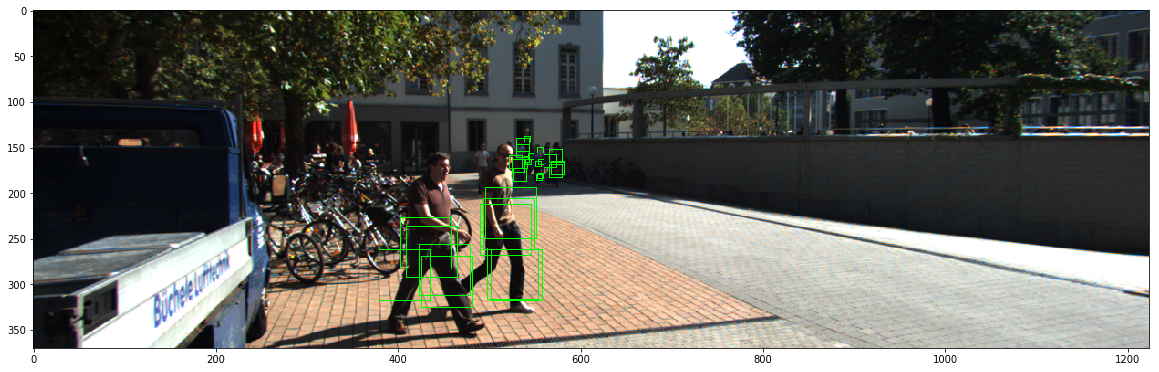

In [6]:
feat_sets = []
pyr_levels = []

st = datetime.now()
for i in range(len(r['class_ids'])):

    # feature pyramid that corresponds to object size
    pyramid_level = int(np.floor(4+np.log2(1/224*np.sqrt(np.abs((r['rois'][i,2]-r['rois'][i,0])*(r['rois'][i,3]-r['rois'][i,1]))))))
    pyr_levels += [pyramid_level]

    # run a erosion to get samples inside masks
    kernel = np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,1,1,1],[0,1,1,1,0],[0,0,1,0,0]] ,np.uint8)
    if pyramid_level > 2:
        mask_image = cv2.erode((r['masks'][:,:,i]).astype(np.uint8), kernel, iterations=1).astype(bool)
    else:
        mask_image = r['masks'][:,:,i]

    # feature pyramid particle constants that correspond to object size
    M1, M2 = pyr_sizes(pyramid_level) 
    N1, N2 = num_particles(mask_image)

    # sample points inside mask
    points2 = random_sampling(mask_image, N2)

    M1 = M1//2
    M2 = M2//2
    # points to bounding boxes

    bboxes2 = np.array([[ point[0]-M2, point[1]-M2, point[0]+M2, point[1]+M2 ] for point in points2]+[[0,0,0,0]])
    bboxes_abs2 = bboxes2.copy() 

    # normalize bboxes to pass for encoding
    bboxes2 = np.array([normalize_boxes(bboxes2, image.shape[:2])])

    # encoding
    app2 = roi_model.rois_encode(bboxes2,r['metas'],r['fp_maps'][0],r['fp_maps'][1],
                r['fp_maps'][2],r['fp_maps'][3])

    # vectorize feature roi pooled maps
    app2_list = [app2[0,i,:,:,:].flatten('F') for i in range(app2.shape[1])]
    app2 = np.array(app2_list)

    # remove batch dimension from rois
    bboxes2 = np.squeeze(bboxes2, axis = 0)

    # append features to feature list
    feat_sets += [[bboxes_abs2,app2]]#[[[bboxes1, app1], [bboxes2, app2]]]

    # visualize bounding boxes
    for box in bboxes_abs2[:5]:
    	cv2.rectangle(image,tuple([box[1], box[0]]),tuple([box[3], box[2]]),(0,255,0),1)

print("Appearance encoding of particles (non optimized): {} (hh:mm:ss.ms)".format(datetime.now()-st))

 
plt.figure(figsize=(20,20))
print('A sample of the sampled bounding boxes over each object')
plt.imshow(image)

### Saving objects and results for the first frame

The object data are saved in an object oriented way using a list of tracked-object class instances. 

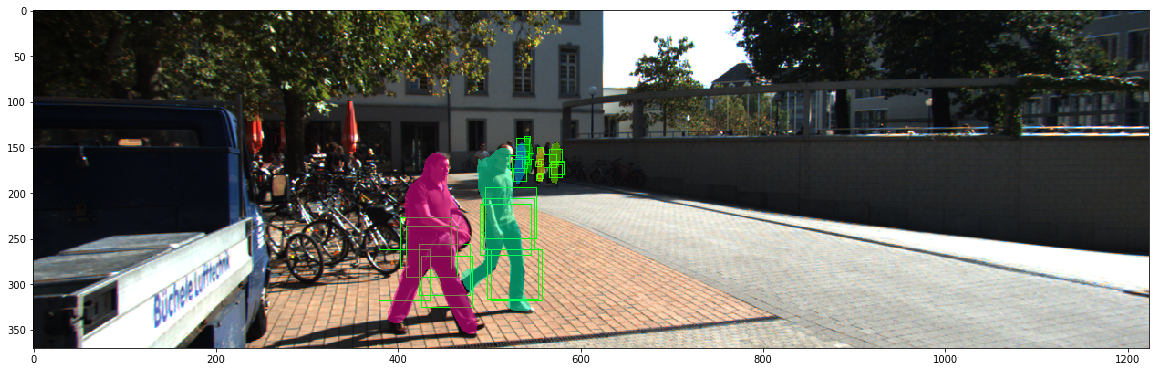

In [7]:
lost_obj = []
obj_list = []
track_id = 0
# for each object initialize trackedObject
for i in range(len(r['class_ids'])):

    obj_list += [tob(track_id, r['masks'][:,:,i], r['rois'][i,:],
                    r['class_ids'][i], feat_sets[i])]
    track_id += 1
    
# save first frame
res_im = save_instances(image, r['rois'], r['masks'], r['class_ids'], 
                    class_names, ids = [str(x.id)[:4] for x in obj_list], 
                    file_name = str(0)+'.png', colors=[x.color for x in obj_list])

plt.figure(figsize=(20,20))
plt.imshow(res_im)

# delete file contents if exist
open(trackf, 'w').close()
# write first frame track results
with open(trackf, 'a') as trf:
    for obj in obj_list:
        if obj.tracking_state == 'New' or obj.tracking_state == 'Tracked':
            trf.write("{} {} {} 0 0 -10.0 {} {} {} {} -1000.0 -1000.0 -1000.0 -10.0 -1 -1 -1 {}\n".format(
                        0, obj.id, class_names[obj.class_name], 
                        float(obj.bbox[1]), float(obj.bbox[0]), float(obj.bbox[3]), float(obj.bbox[2]), 1))


### Running MOT algorithm
The previous steps can be seen as the initialization step for tracking. Now I run my MOT algorithm for the following frames. I run it for a single frame to enable code snippet commenting.

### Detections and encoding particles 

Appearance encoding of particles: 0:00:01.314100 (hh:mm:ss.ms)


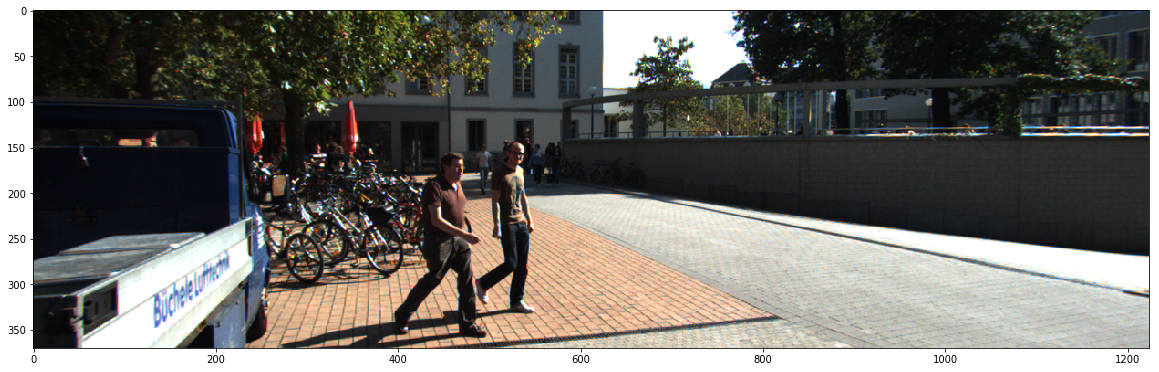

In [8]:
frame = frames[1]
jj = 1

# read frame
image = skimage.io.imread(os.path.join(IMAGE_DIR,frame))

plt.figure(figsize=(20,20))
plt.imshow(image)

f = open(join(pickle_dir, pickles[jj]),'rb')
r = pickle.load(f)

# Run roi encoding for appearance description
rois = r['detections'][:,:,0:4]

feat_sets = []
pyr_levels = []

st = datetime.now()
for i in range(len(r['class_ids'])):

    # feature pyramid that corresponds to object size
    pyramid_level = int(np.floor(4+np.log2(1/224*np.sqrt(np.abs((r['rois'][i,2]-r['rois'][i,0])*(r['rois'][i,3]-r['rois'][i,1]))))))
    pyr_levels += [pyramid_level]

    kernel = np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,1,1,1],[0,1,1,1,0],[0,0,1,0,0]] ,np.uint8)

    if pyramid_level > 2:
        mask_image = cv2.erode((r['masks'][:,:,i]).astype(np.uint8), kernel, iterations=1).astype(bool)
    else:
        mask_image = r['masks'][:,:,i]
        
    # feature pyramid particle constants that correspond to object size
    # 1: same pyramid
    # 2: lower pyramid
    M1, M2 = pyr_sizes(pyramid_level) 
    N1, N2 = num_particles(mask_image)

    # sample points inside mask
    points2 = random_sampling(mask_image, N2)

    M1 = M1//2
    M2 = M2//2
    # points to bounding boxes
    bboxes2 = np.array([[ point[0]-M2, point[1]-M2, point[0]+M2, point[1]+M2 ] for point in points2]+[[0,0,0,0]])
    bboxes_abs2 = bboxes2.copy()

    # normalize bboxes
    bboxes2 = np.array([normalize_boxes(bboxes2, image.shape[:2])])

    # encoding
    app2 = roi_model.rois_encode(bboxes2,r['metas'],r['fp_maps'][0],r['fp_maps'][1],
                r['fp_maps'][2],r['fp_maps'][3])

    # vectorize feature roi pooled maps
    app2_list = [app2[0,i,:,:,:].flatten('F') for i in range(app2.shape[1])]
    app2 = np.array(app2_list)

    # remove batch dimension from rois
    bboxes2 = np.squeeze(bboxes2, axis = 0)

    # append features to feature list
    feat_sets += [[bboxes_abs2, app2]]#[[[bboxes1, app1], [bboxes2, app2]]]

print("Appearance encoding of particles: {} (hh:mm:ss.ms)".format(datetime.now()-st))


### Creation of a temporary list of objects
...to compare with all active previous objects


In [9]:
# for each newly found object initialize trackedObject
temp_list = []
temp_scores = []
for i in range(len(r['class_ids'])):

    # initialize tracked Objects for this current frame
    temp_list += [tob(uuid.uuid4(), r['masks'][:,:,i], r['rois'][i,:],
                    r['class_ids'][i], feat_sets[i])]
    temp_scores += [r['scores'][i]]

### Data association

In this step I create a matrix of dissimilarity between newly found objects and previous objects. The dissimilarity score is computed using the [best buddies similarity (bbs)](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Dekel_Best-Buddies_Similarity_for_2015_CVPR_paper.pdf) metric. Bbs is a rank metric: It counts the pairs of points being mutually closest in both images we compare.  

In [10]:
st = datetime.now()
peek_matrix = np.zeros((len(obj_list),len(temp_list)))
for i in range(len(obj_list)):
    for j in range(len(temp_list)):
        peek_matrix[i,j] = 1-bbs(obj_list[i],temp_list[j])
        
# pad cost matrix if more old objects than new objects
if peek_matrix.shape[0] > peek_matrix.shape[1]:
    peek_matrix = squarify(peek_matrix, 100)

print(peek_matrix)
print("Computing the data association matrix: {} (hh:mm:ss.ms)".format(datetime.now()-st))


[[0.557 0.725 0.967 0.903 0.943 0.926]
 [0.662 0.625 0.9   0.871 0.857 0.852]
 [0.871 0.903 0.633 0.71  0.806 0.815]
 [0.889 0.889 0.704 0.556 0.778 0.852]
 [0.929 0.893 0.821 0.607 0.786 0.778]
 [0.903 0.871 0.733 0.774 0.742 0.63 ]]
Computing the data association matrix: 0:00:03.729489 (hh:mm:ss.ms)


### Solving the assignment problem
I use the Hungarian algorithm to compute the optimal assignment of newly found objects and previous objects. Optimal: Minimizing the dissimilarity penalty of the assignment.

In [11]:
st = datetime.now()

# run assignment (appearance model)
row_ind, col_ind = linear_sum_assignment(peek_matrix)

print("Assignment problem solving: {} (hh:mm:ss.ms)".format(datetime.now()-st))
st = datetime.now() 	

# log assignment
print('Rows: {}'.format(row_ind))
print('Cols: {}'.format(col_ind))

matching_scores = []
for i in row_ind:
    matching_scores += [peek_matrix[i,col_ind[i]]]
print('Scores: {}'.format(np.array(matching_scores)))

Assignment problem solving: 0:00:00.001028 (hh:mm:ss.ms)
Rows: [0 1 2 3 4 5]
Cols: [0 1 2 3 4 5]
Scores: [0.557 0.625 0.633 0.556 0.786 0.63 ]


### Update object data

In [12]:
num_old = len(obj_list)
num_new = len(temp_list)
temp_matched = [False]*num_new

# propagate previous objects in new frame
for i in range(num_old):
    # if there is a match (old>temp)
    if col_ind[i] < num_new:
        # refress data
        obj_list[i].refresh_state(True)
        obj_list[i].mask = temp_list[col_ind[i]].mask
        obj_list[i].encoding = temp_list[col_ind[i]].encoding
        obj_list[i].class_name = temp_list[col_ind[i]].class_name
        temp_matched[col_ind[i]] = True
    # if there is no match, this object is occluded in this frame (or lost if it 
    # is occluded for more than N frames)
    else:
        obj_list[i].refresh_state(False)

# initialize new objects
det_thresh = 0.7
for i in range(num_new):
    # for new object initialization the detection score should be >= det_thresh
    if not temp_matched[i] and temp_scores[i] >= det_thresh:
        temp_list[i].id = track_id
        track_id += 1
        obj_list += [temp_list[i]]

### Saving results

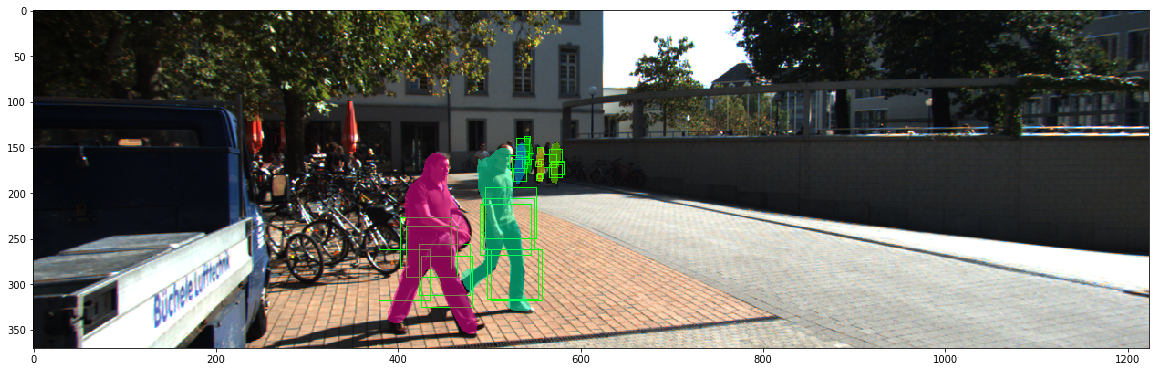

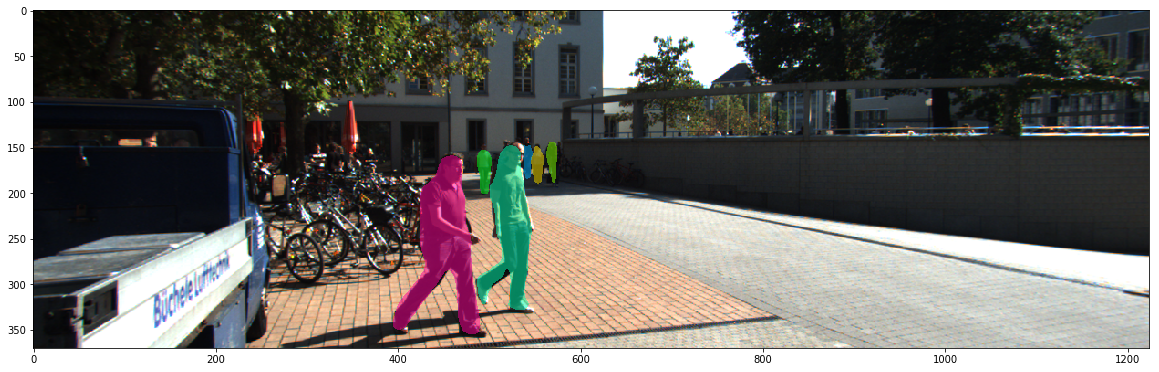

In [13]:
# keep objects appeared in current frame
obj_list_fr = [x for x in obj_list if x.tracking_state=='Tracked' or x.tracking_state=='New']
num_obj = len(obj_list_fr)

# Prepare object data for saving image
boxes = np.empty([num_obj,4])
masks = np.empty([image.shape[0], image.shape[1], num_obj])
for i in range(num_obj):
    # boxes[i,:] = obj_list_fr[i].bbox_pred
    boxes[i,:] = obj_list_fr[i].bbox
    masks[:,:,i] = obj_list_fr[i].mask

# save current frame with found objects
res_im1 = save_instances(image, boxes, masks, [x.class_name for x in obj_list_fr], 
                class_names, ids = [str(x.id)[:4] for x in obj_list_fr], 
                file_name = str(jj)+'.png',colors=[x.color for x in obj_list_fr])

plt.figure(figsize=(20,20))
plt.imshow(res_im)
plt.figure(figsize=(20,20))
plt.imshow(res_im1)

with open(trackf, 'a') as trf:
    for obj in obj_list:
        if obj.tracking_state == 'New' or obj.tracking_state == 'Tracked':
            trf.write("{} {} {} 0 0 -10.0 {} {} {} {} -1000.0 -1000.0 -1000.0 -10.0 -1 -1 -1 {}\n".format(
                        jj, obj.id, class_names[obj.class_name], 
                        float(obj.bbox[1]), float(obj.bbox[0]), float(obj.bbox[3]), float(obj.bbox[2]), 1))

# remove lost objects
lost_obj += [x for x in obj_list if x.tracking_state=='Lost']
obj_list = [x for x in obj_list if x.tracking_state!='Lost']

### Comments
Using this framework I use a strictly appearance based correlation of objects among frames. In literature and practice we stumble upon solutions like [SORT](https://github.com/abewley/sort), which use motion prediction and bounding box correlation techniques. I observed that such solutions are not robust to camera movements. I also dismissed almost all motion modeling-regressing ideas like optical flow for the same reason. I tried to come up with a solution that deals with camera movements and the following:

* The occlussion problem: Objects naturally become partially occluded by other objects or structures. Multiple particles allow as to use a robust metric in this case. I also sample particles inside the masks (outputed by the detector) to reduce outliers.
* The appearance drift: While objects move, their apperance slowly changes. I will implement a particle filter-like to handle this problem.
* The re-identification problem: If an object is fully occluded we keep a robust appearance description in the case it appears again.

I also use the detector with a lower detection score threshold and let the MOT algorithm to determine if it is a valid object (if it is matched with a previous object). New objects are initialized using the initial high score threshold. In this implementation these are 0.2 and 0.7.  

In this demo I used samples from a single scale (pyramid level). To deal with objects moving away (and getting smaller) and partial occlusions I should also draw samples from a lower scale.  

### Literature
I found the following papers trying to back up my appearance particle filter idea. There is a paper using this approach for single object tracking using the detect by tracking framework. I also pumped ideas from the template matching literature.

* [Deep Semantic Feature Matching](http://openaccess.thecvf.com/content_cvpr_2017/papers/Ufer_Deep_Semantic_Feature_CVPR_2017_paper.pdf) Template matching using pyramid features
* [Best-Buddies Similarity for Robust Template Matching](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Dekel_Best-Buddies_Similarity_for_2015_CVPR_paper.pdf) Describing the best buddies similarity metric
* [Best-Buddies Tracking](https://arxiv.org/pdf/1611.00148.pdf) Using bbs for detect-by-track single object tracking. Comments on bbs bias and occlusions.
* [Maximum-Likelihood Image Matching](https://ieeexplore.ieee.org/document/1008392/), Olson, 2002 Introducing image pdf: p(x,y,I), x,y pixel coords, I intensity

### Other Ideas

#### A problem with Hungarian Algorithm
Assume that frames n and n+1 include 4 objects:
* a,b,c,d
* a,b,c,e

So, three out of four objects are matches and the other is not.

A weakness of the hungarian algorithm for MOT is that it matches d and e. For this case, I've thought of two options:

1) Set a similarity threshold. If score(d,e)<thresh, discard the matching. Setting such thresholds are found to be non optimal in my experiments. I also try to avoid thresholds in general.

2) Let a classifier determine the matching. 

#### Re-training MaskRCNN 
My detector is trained using COCO dataset (the out-of-the-box implementation in matterplot). I should re-train the RCNN using datasets like [BDD100K](http://bair.berkeley.edu/blog/2018/05/30/bdd/) and [Apolloscapes](http://apolloscape.auto/)  
